## Backpropagation

In [1]:
import torch
from sklearn import datasets
import matplotlib.pyplot as plt
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
import numpy as np

### Bakwardをスクラッチで実装

In [2]:
def linear_backward(A, W, b, Z):
    W.grad_ = Z.grad_.T @ A
    b.grad_ = torch.sum(Z.grad_, dim=0) # バイアス項は全てのデータに加算される形になるので，逆伝播時には集約する
    A.grad_ = Z.grad_ @ W
    
def relu_backward(Z, A):
    # 入力が正なら1(True)として，負なら0(False), それぞれの要素をマスクする
    Z.grad_ = A.grad_ * (Z>0).float()

In [3]:
# softmaxとcrossentropyを同じ関数にする（する必要はないが，pytorchの実装に合わせている
def softmax_cross_entropy(x, y_true):
    e_x = torch.exp(x - torch.max(x, dim=-1, keepdim=True)[0])
    softmax_out =  e_x / (torch.sum(e_x, dim=-1, keepdim=True) + 1e-10)
    loss = -torch.sum(y_true * torch.log(softmax_out + 1e-10)) / y_true.shape[0]
    return loss, softmax_out

In [4]:
def linear(X, W, b):
    return X@W.T + b
def relu(Z):
    return Z.clamp_min(0.)
def forward_and_backward(X, y):
    # forward
    Z1 = linear(X, W1, b1)
    Z1.retain_grad()
    A1 = relu(Z1)
    A1.retain_grad()
    Z2 = linear(A1, W2, b2)
    Z2.retain_grad()
    loss, A2 = softmax_cross_entropy(Z2, y)

    # backward
    Z2.grad_ = (A2 - y) / X.shape[0]
    linear_backward(A1, W2, b2, Z2)
    relu_backward(Z1, A1)
    linear_backward(X, W1, b1, Z1)
    return loss, Z1, A1, Z2, A2

### Autogradの結果と一致することを確認

In [5]:
# 1. データロード
dataset = datasets.load_digits()
images = dataset['images']
target = dataset['target']

# 学習データと検証データ分割
X_train, X_val, y_train, y_val = train_test_split(images, target, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
# 前処理
# 2-1.ラベルのone-hot encoing
y_train = F.one_hot(torch.tensor(y_train), num_classes=10)
X_train = torch.tensor(X_train, dtype=torch.float32).reshape(-1, 64)

y_val = F.one_hot(torch.tensor(y_val), num_classes=10)
X_val = torch.tensor(X_val, dtype=torch.float32).reshape(-1, 64)

# 2-2. 画像の標準化
X_train = (X_train - X_train.mean()) / X_train.std()
X_val = (X_val - X_train.mean()) / X_train.std()

(1437, 8, 8) (1437,)
(360, 8, 8) (360,)


In [6]:
# パラメータの初期化
m, n = X_train.shape
nh = 30
class_num = 10
# パラメータの初期化
# W1 = torch.randn((nh, n), requires_grad=True) # 出力 x 入力
# Kaiming初期化を使って，softmaxの入力が大きくならないようにする
W1 = torch.randn((nh, n)) * torch.sqrt(torch.tensor(2./n))
W1.requires_grad = True
b1 = torch.zeros((1, nh), requires_grad=True) # 1 x nh

# W2 = torch.randn((class_num, nh), requires_grad=True) # 出力 x 入力
# Kaiming初期化を使って，softmaxの入力が大きくならないようにする
W2 = torch.randn((class_num, nh)) * torch.sqrt(torch.tensor(2./nh))
W2.requires_grad = True
b2 = torch.zeros((1, class_num), requires_grad=True) # 1 x nh
# スクラッチのbackward
loss, Z1, A1, Z2, A2 = forward_and_backward(X_train, y_train)
# PytorchのAutograd
loss.backward()

# autogradと等しいことを確認
print(torch.allclose(W1.grad_, W1.grad))
print(torch.allclose(b1.grad_, b1.grad))
print(torch.allclose(W2.grad_, W2.grad))
print(torch.allclose(b2.grad_, b2.grad))

True
True
True
True


### MLPの学習

In [7]:
learning_rate = 0.03
batch_size = 30
num_batches = np.ceil(len(y_train) / batch_size).astype(int)
loss_log = []
# 3. パラメータの初期化
# パラメータの初期化
W1 = torch.randn((nh, n)) * torch.sqrt(torch.tensor(2./n))
W1.requires_grad = True
b1 = torch.zeros((1, nh), requires_grad=True) # 1 x nh
W2 = torch.randn((class_num, nh)) * torch.sqrt(torch.tensor(2./nh))
W2.requires_grad = True
b2 = torch.zeros((1, class_num), requires_grad=True) # 1 x nh

# ログ
train_losses = []
val_losses = []
val_accuracies = []
# 5. for文で学習ループ作成
epochs = 30
for epoch in range(epochs):
    shuffled_indices = np.random.permutation(len(y_train))
    running_loss = 0
    for i in range(num_batches):

        # mini batch作成
        start = i * batch_size
        end = start + batch_size
        batch_indices = shuffled_indices[start:end]
        # 6. 入力データXおよび教師ラベルのYを作成
        y_true_ = y_train[batch_indices, :] # データ数xクラス数
        X = X_train[batch_indices, :] # データ数 x 特徴量数
        # import pdb; pdb.set_trace()

        # 7. Z計算
        # Z = X@W.T + b # -> MLP
        Z1 = linear(X, W1, b1)
        A1 = relu(Z1)
        Z2 = linear(A1, W2, b2)
        loss, A2 = softmax_cross_entropy(Z2, y_true_)

        # 8. softmaxで予測計算
        # y_pred = softmax(Z)

        # 9. 損失計算
        # loss = cross_entropy(y_true_, y_pred) #-> softmax_cross_entropy
        loss_log.append(loss.item())
        running_loss += loss.item()
        
        # 10. 勾配計算
        # loss.backward() # -> scratchのbackward
        Z2.grad_ = (A2 - y_true_) / X.shape[0]
        linear_backward(A1, W2, b2, Z2)
        relu_backward(Z1, A1)
        linear_backward(X, W1, b1, Z1)

        # 11. パラメータ更新
        with torch.no_grad():
            W1 -= learning_rate * W1.grad_ # .grad -> .grad_
            W2 -= learning_rate * W2.grad_ # .grad -> .grad_
            b1 -= learning_rate * b1.grad_
            b2 -= learning_rate * b2.grad_

        # 12. 勾配初期化
        # W.grad.zero_() # .grad_ = None
        # b.grad.zero_()
            W1.grad_ = None
            W2.grad_ = None
            b1.grad_ = None
            b2.grad_ = None
    # validation
    with torch.no_grad():
        # Z_val = X_val@W.T + b # -> MLP
        Z1_val = linear(X_val, W1, b1)
        A1_val = relu(Z1_val)
        Z2_val = linear(A1_val, W2, b2)
        val_loss, A2_val = softmax_cross_entropy(Z2_val, y_val)
        # y_pred_val = softmax(Z_val)

        # val_loss = cross_entropy(y_val, y_pred_val) #-> softmax_cross_entropy
        val_accuracy = torch.sum(torch.argmax(A2_val, dim=-1) == torch.argmax(y_val, dim=-1)) / y_val.shape[0]

    train_losses.append(running_loss/num_batches)
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy.item())
        
    # 13. 損失ログ出力
    print(f'epoch: {epoch+1}: train loss:{running_loss/num_batches}, val loss: {val_loss.item()}, val accuracy: {val_accuracy.item()}')

epoch: 1: train loss:1.8424878443280857, val loss: 3.9936957359313965, val accuracy: 0.4333333373069763
epoch: 2: train loss:0.937017884105444, val loss: 2.586479663848877, val accuracy: 0.6333333253860474
epoch: 3: train loss:0.5741765623291334, val loss: 1.9767118692398071, val accuracy: 0.7222222089767456
epoch: 4: train loss:0.4157436192035675, val loss: 1.684888243675232, val accuracy: 0.7805555462837219
epoch: 5: train loss:0.330823608674109, val loss: 1.3481305837631226, val accuracy: 0.8111110925674438
epoch: 6: train loss:0.27900383714586496, val loss: 1.1966313123703003, val accuracy: 0.8305555582046509
epoch: 7: train loss:0.244715781416744, val loss: 1.0972546339035034, val accuracy: 0.8444444537162781
epoch: 8: train loss:0.2180399401113391, val loss: 1.1595005989074707, val accuracy: 0.8416666388511658
epoch: 9: train loss:0.19901746977120638, val loss: 1.117865800857544, val accuracy: 0.8527777791023254
epoch: 10: train loss:0.1831873545112709, val loss: 1.06796753406524

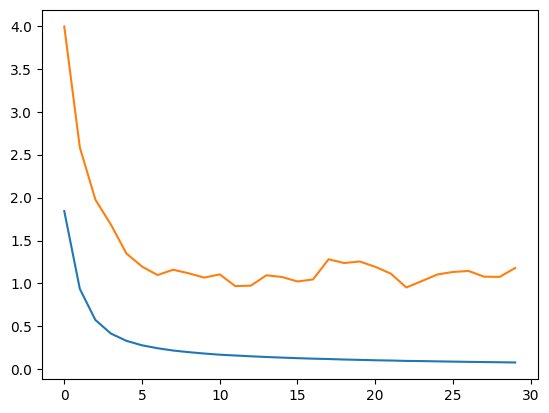

In [8]:
plt.plot(train_losses)
plt.plot(val_losses)

### 回帰NNのbackprop

In [9]:
y_train_reg = torch.argmax(y_train, dim=-1)

def mse(X, y):
    return (X[:, 0] - y).pow(2).mean()

def forward_and_backward(X, y):
    # forward
    Z1 = linear(X, W1, b1)
    Z1.retain_grad()
    A1 = relu(Z1)
    A1.retain_grad()
    Z2 = linear(A1, W2, b2)
    Z2.retain_grad()
    # loss, A2 = softmax_cross_entropy(Z2, y) # -> MSE
    loss = mse(Z2, y)

    # backward
    # Z2.grad_ = (A2 - y) / X.shape[0] # -> MSE
    Z2.grad_ = 2 * (Z2 - y.unsqueeze(dim=-1)) / X.shape[0]
    linear_backward(A1, W2, b2, Z2)
    relu_backward(Z1, A1)
    linear_backward(X, W1, b1, Z1)
    return loss, Z1, A1, Z2, A2
    
# パラメータの初期化
m, n = X_train.shape
nh = 30
# パラメータの初期化
W1 = torch.randn((nh, n), requires_grad=True) # 出力 x 入力
b1 = torch.zeros((1, nh), requires_grad=True) # 1 x nh

W2 = torch.randn((1, nh), requires_grad=True) # 出力 x 入力
b2 = torch.zeros((1, 1), requires_grad=True) # 1 x 1
loss, Z1, A1, Z2, A2 = forward_and_backward(X_train, y_train_reg)
loss.backward()

# autogradと等しいことを確認
print(torch.allclose(W1.grad_, W1.grad))
print(torch.allclose(b1.grad_, b1.grad))
print(torch.allclose(W2.grad_, W2.grad))
print(torch.allclose(b2.grad_, b2.grad))

False
True
True
True


In [10]:
y_train_reg = torch.argmax(y_train, dim=-1)

### Refactoring

In [11]:
# ======モデル======
class Linear():
    def __init__(self, in_features, out_features):
        self.W = torch.randn((out_features, in_features)) * torch.sqrt(torch.tensor(2.0 / in_features))
        self.W.requires_grad = True
        self.b = torch.zeros((1, out_features), requires_grad=True)
        
    def forward(self, X):
        self.X = X
        self.Z = X @ self.W.T + self.b
        return self.Z

    def backward(self, Z):
        self.W.grad_ = Z.grad_.T @ self.X
        self.b.grad_ = torch.sum(Z.grad_, dim=0)
        self.X.grad_ = Z.grad_ @ self.W
        return self.X.grad_

class ReLU():
    def forward(self, X):
        self.X = X
        return X.clamp_min(0.)

    def backward(self, A):
        return A.grad_ * (self.X > 0).float()

class SoftmaxCrossEntropy:
    def forward(self, X, y):
        e_x = torch.exp(X - torch.max(X, dim=-1, keepdim=True)[0])
        self.softmax_out = e_x / (torch.sum(e_x, dim=-1, keepdim=True) + 1e-10)    
        
        log_probs = torch.log(self.softmax_out + 1e-10)
        target_log_probs = log_probs * y

        self.loss = -target_log_probs.sum(dim=-1).mean()
        return self.loss

    def backward(self, y):
        return (self.softmax_out - y) / y.shape[0]

class Model:
    def __init__(self, input_features, hidden_units, output_units):
        self.linear1 = Linear(input_features, hidden_units)
        self.relu = ReLU()
        self.linear2 = Linear(hidden_units, output_units)
        self.loss_fn = SoftmaxCrossEntropy()
        
    def forward(self, X, y):
        self.X = X
        self.Z1 = self.linear1.forward(X)
        self.A1 = self.relu.forward(self.Z1)
        self.Z2 = self.linear2.forward(self.A1)
        self.loss = self.loss_fn.forward(self.Z2, y)
        return self.loss, self.Z2
    
    def backward(self, y):
        self.Z2.grad_ = self.loss_fn.backward(y)
        self.A1.grad_ = self.linear2.backward(self.Z2)
        self.Z1.grad_ = self.relu.backward(self.A1)
        self.X.grad_ = self.linear1.backward(self.Z1)

    def zero_grad(self):
        # 勾配の初期化
        self.linear1.W.grad_ = None
        self.linear1.b.grad_ = None
        self.linear2.W.grad_ = None
        self.linear2.b.grad_ = None
        
    def step(self, learning_rate):
        # パラメータの更新
        self.linear1.W -= learning_rate * self.linear1.W.grad_
        self.linear1.b -= learning_rate * self.linear1.b.grad_
        self.linear2.W -= learning_rate * self.linear2.W.grad_
        self.linear2.b -= learning_rate * self.linear2.b.grad_

## Refactoring後の学習ループ(OptimizerやDataset, Dataloaderは後ほどRefactoring)
# ===データの準備====
dataset = datasets.load_digits()
data = dataset['data']
target = dataset['target']
images = dataset['images']
X_train, X_val, y_train, y_val = train_test_split(images, target, test_size=0.2, random_state=42)
X_train = (X_train - X_train.mean()) / X_train.std()
X_val = (X_val - X_train.mean()) / X_train.std()
X_train = torch.tensor(X_train.reshape(-1, 64), dtype=torch.float32)
X_val = torch.tensor(X_val.reshape(-1, 64), dtype=torch.float32)
y_train = F.one_hot(torch.tensor(y_train), num_classes=10) #1437 x 10 
y_val = F.one_hot(torch.tensor(y_val), num_classes=10) # 360 x 10
batch_size = 30
# モデルの初期化
model = Model(input_features=64, hidden_units=10, output_units=10)

learning_rate = 0.01

# ログ
train_losses = []
val_losses = []
val_accuracies = []
for epoch in range(100):
    # エポック毎にデータをシャッフル
    shuffled_indices = np.random.permutation(len(y_train))
    num_batches = np.ceil(len(y_train)/batch_size).astype(int)
    running_loss = 0.0
    
    for i in range(num_batches):
        
        # mini batch作成
        start = i * batch_size
        end = start + batch_size

        batch_indices = shuffled_indices[start:end]
        y_true_ = y_train[batch_indices, :] # batch_size x 10
        
        X = X_train[batch_indices] # batch_size x 64
        # 順伝播と逆伝播の計算
        loss, _ = model.forward(X, y_true_)
        model.backward(y_true_)
        running_loss += loss.item()

        # パラメータ更新
        with torch.no_grad():
            model.step(learning_rate)

        model.zero_grad()

    # validation
    with torch.no_grad():
        val_loss, Z2_val = model.forward(X_val, y_val)
        
        val_accuracy = torch.sum(torch.argmax(Z2_val, dim=-1) == torch.argmax(y_val, dim=-1)) / y_val.shape[0]

    train_losses.append(running_loss/num_batches)
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy)
    print(f'epoch: {epoch}: train error: {running_loss/num_batches}, validation error: {val_loss.item()}, validation accuracy: {val_accuracy}')

epoch: 0: train error: 2.3414133116602898, validation error: 9.969054222106934, validation accuracy: 0.15555556118488312
epoch: 1: train error: 1.9317669421434402, validation error: 8.740021705627441, validation accuracy: 0.19722221791744232
epoch: 2: train error: 1.7252780000368755, validation error: 8.2929048538208, validation accuracy: 0.2361111044883728
epoch: 3: train error: 1.558756907780965, validation error: 8.039956092834473, validation accuracy: 0.2666666805744171
epoch: 4: train error: 1.4132022534807522, validation error: 7.559729099273682, validation accuracy: 0.28611111640930176
epoch: 5: train error: 1.2803218724826972, validation error: 7.201395034790039, validation accuracy: 0.31388887763023376
epoch: 6: train error: 1.1579220928251743, validation error: 6.90744686126709, validation accuracy: 0.3361110985279083
epoch: 7: train error: 1.0501447257896264, validation error: 6.332675457000732, validation accuracy: 0.3638888895511627
epoch: 8: train error: 0.957085984448591